In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein)
from utils import get_device, get_noise, init_weights, plot_tensor_images, plot_losses
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist

torch.set_default_dtype(torch.float64)

In [2]:
# create dataloader
batch_size = 128

# get device to train on
device = get_device()


train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)



In [3]:
device

'cuda:0'

Time is 0.01801776885986328 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


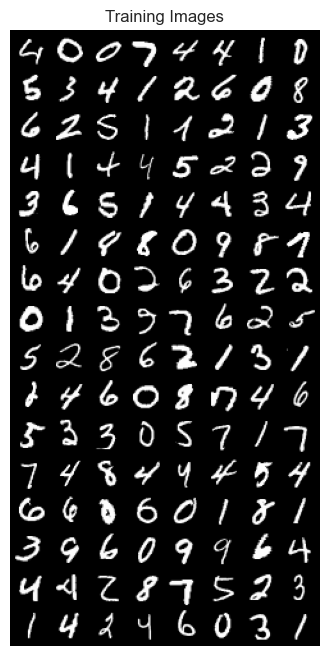

In [4]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [5]:
latent_dim = 100
training_params = TrainingParams(lr=0.0002, num_epochs=1, num_dis_updates=5, beta_1=0.5, batch_size=batch_size)
test_noise = get_noise(batch_size, latent_dim, device)

## First I train a Wasserstein GAN

In [6]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist().apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device)

In [7]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, noise_dim=latent_dim)

done, took 544.7 seconds.468


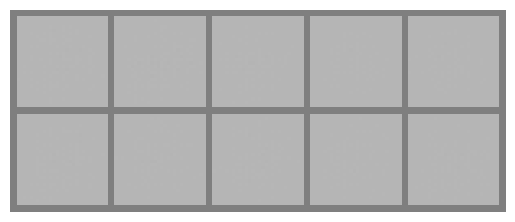

In [9]:
# show generated images
generated_images_wasserstein = (trained_wgan.generator(test_noise)+1)/2
plot_tensor_images(generated_images_wasserstein, num_images=10)

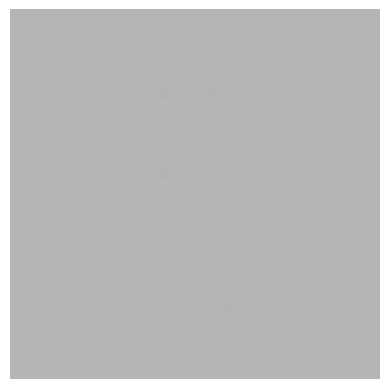

In [10]:
plot_tensor_images(generated_images_wasserstein[100,0])

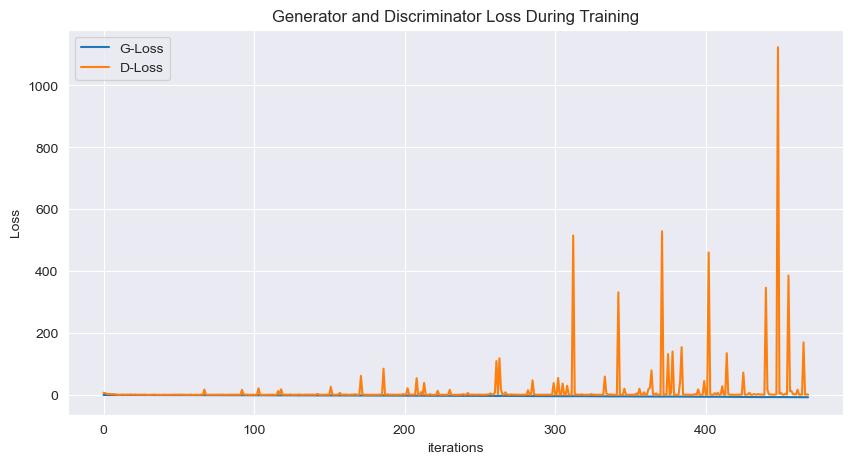

In [11]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

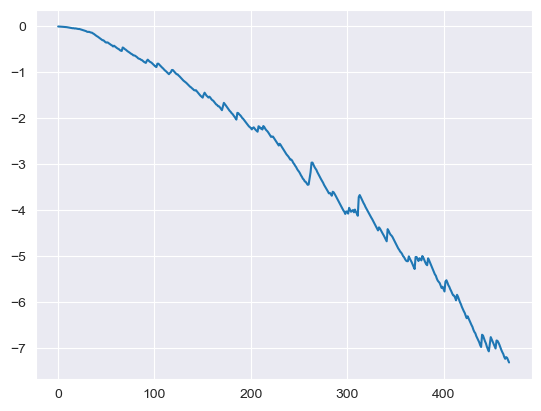

In [12]:
plt.plot(trained_wgan.generator_losses)

## BHS Gan

In [96]:
generator_bhs = GeneratorBhsMnist(latent_dim).apply(init_weights)
discriminator_bhs = DiscriminatorBhsMnist().apply(init_weights)
trainer_bhs = Trainer(training_params, generator_bhs, discriminator_bhs)

In [97]:
# training loop
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, noise_dim=latent_dim)

Epoch 0 training... done, took 359.9 seconds.
Epoch 1 training... done, took 323.7 seconds.
Epoch 2 training... done, took 324.9 seconds.
Epoch 3 training... done, took 347.6 seconds.
Epoch 4 training... done, took 368.2 seconds.
Epoch 5 training... done, took 373.0 seconds.
Epoch 6 training... done, took 401.2 seconds.
Epoch 7 training... done, took 368.3 seconds.
Epoch 8 training... done, took 361.8 seconds.
Epoch 9 training... done, took 366.1 seconds.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


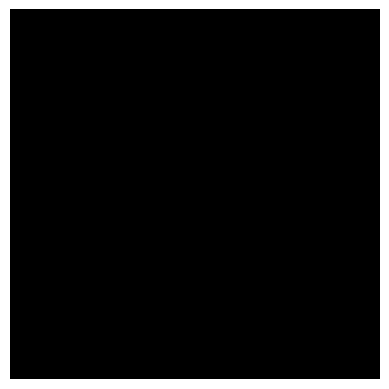

In [98]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise)
plot_tensor_images(generated_images_bhs, num_images=25)

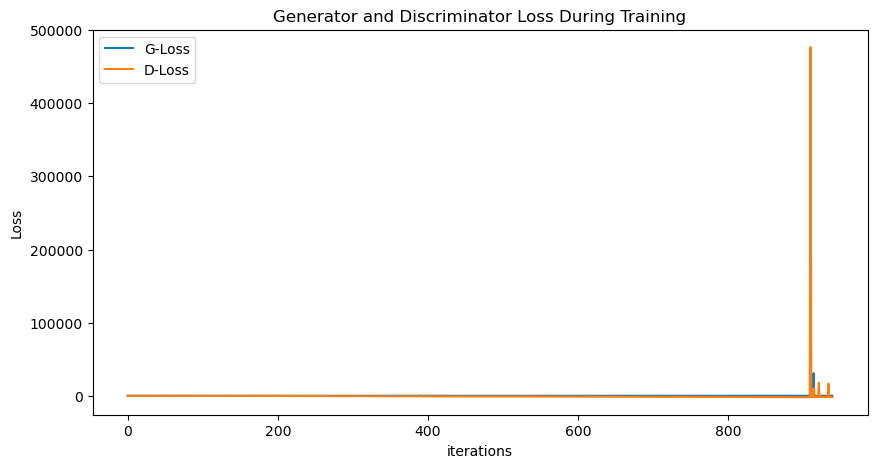

In [99]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## IPM BHS GAN

In [100]:
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist().apply(init_weights)
trainer_ipm = Trainer(training_params, generator_ipm, discriminator_ipm)

In [101]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, noise_dim=latent_dim)

Epoch 0 training... done, took 315.5 seconds.
Epoch 1 training... done, took 306.4 seconds.
Epoch 2 training... done, took 305.6 seconds.
Epoch 3 training... done, took 305.7 seconds.
Epoch 4 training... done, took 303.9 seconds.
Epoch 5 training... done, took 307.3 seconds.
Epoch 6 training... done, took 302.9 seconds.
Epoch 7 training... done, took 303.5 seconds.
Epoch 8 training... 

In [ ]:
# show generated images
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=25)

In [ ]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)